In [ ]:
!pip install nx-arangodb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 26.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.6/114.6 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 3.4.2
    Uninstalling networkx-3.4.2:
      Successfully uninstalled networkx-3.4.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which

In [ ]:
!nvidia-smi
!nvcc --version

/bin/bash: line 1: nvidia-smi: command not found
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [ ]:
!pip install nx-cugraph-cu12 --extra-index-url https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


In [ ]:
!pip install --upgrade langchain langchain-community langchain-openai langgraph

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.4/151.4 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 414.3/414.3 kB 22.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 24.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.4 MB/s eta 0:00:00
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.3.37
    Uninstalling langchain-core-0.3.37:
      Successfully uninstalled langchain-core-0.3.37


In [ ]:
import networkx as nx
import nx_arangodb as nxadb

from arango import ArangoClient

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import re

from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from langchain_community.graphs import ArangoGraph
from langchain_community.chains.graph_qa.arangodb import ArangoGraphQAChain
from langchain_core.tools import tool

[04:02:54 +0000] [INFO]: NetworkX-cuGraph is available.
INFO:nx_arangodb:NetworkX-cuGraph is available.


In [ ]:
# import os

# os.environ["DATABASE_HOST"] = "https://bad64b5a91c6.arangodb.cloud:8529"
# # os.environ["DATABASE_USERNAME"] = "root"
# os.environ["DATABASE_PASSWORD"] = "9u17nIbeG0yGs7fxBIMA"
# os.environ["DATABASE_NAME"] = "_system"

In [ ]:
client = ArangoClient(
    hosts="https://bad64b5a91c6.arangodb.cloud:18529", verify_override="/content/ca-ebdc5eb3.crt"
)

sys_db = client.db("_system", username="root", password="9u17nIbeG0yGs7fxBIMA", verify=True)

In [ ]:
customers_df = pd.read_csv('customers.csv')
transactions_df = pd.read_csv('transactions.csv')

In [ ]:
G = nx.MultiDiGraph()

# --- Add Customer Nodes and Their Bank Accounts ---
for _, row in customers_df.iterrows():
    customer_id = row['customer_id']
    cust_node = f"customer_{customer_id}"

    # Add the customer node with attributes.
    G.add_node(cust_node,
               node_type="customer",
               name=row['name'],
               age=row['age'],
               email=row['email'],
               address=row['address'])

    # Process bank accounts (stored as a comma-separated string).
    accounts = row['bank_accounts']
    for acct in accounts:
        acct_node = f"account_{acct}"
        # Add the account node if it doesn't exist.
        if acct_node not in G:
            G.add_node(acct_node, node_type="account", account_id=acct)
        # Add an edge from customer to account to represent ownership.
        G.add_edge(cust_node, acct_node, relation="owns")

# --- Add Transaction Edges ---
for _, row in transactions_df.iterrows():
    source_acct = row['source_account']
    dest_acct = row['destination_account']

    source_node = f"account_{source_acct}"
    dest_node = f"account_{dest_acct}"

    # Ensure the source node exists (if not, add it).
    if source_node not in G:
        G.add_node(source_node, node_type="account", account_id=source_acct)

    # For destination, check if it exists; if not, it's likely an external account.
    if dest_node not in G:
        G.add_node(dest_node, node_type="external", account_id=dest_acct)

    # Create the edge attributes from the transaction.
    edge_attr = {
        "transaction_id": row['transaction_id'],
        "timestamp": row['timestamp'],
        "transaction_type": row['transaction_type'],
        "amount": row['amount'],
        "ip_address": row['ip_address'],
        "device_id": row['device_id'],
        "location": row['location'],
        "channel": row['channel'],
        "is_fraud": row['is_fraud'],
        "fraud_type": row['fraud_type']
    }

    # Add the transaction edge from the source account to the destination account.
    G.add_edge(source_node, dest_node, **edge_attr)

# --- Quick Summary of the Graph ---
print("Graph loaded. Summary:")
print(G.number_of_nodes())
print(G.number_of_edges())
print(G)

Graph loaded. Summary:
1427
6600
MultiDiGraph with 1427 nodes and 6600 edges


In [ ]:
sub_nodes = list(G.nodes)[:10]  # Select N nodes
subG = G.subgraph(sub_nodes)

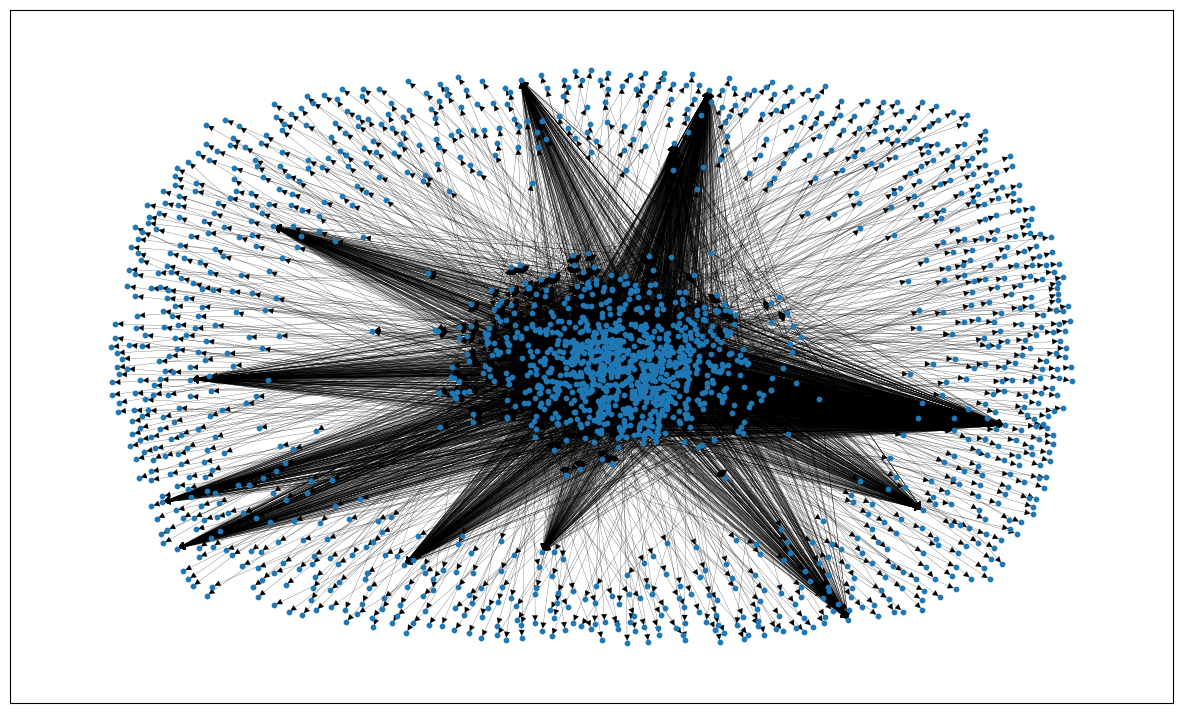

In [ ]:
plot_options = {"node_size": 10, "with_labels": False, "width": 0.15}
pos = nx.spring_layout(G, iterations=15, seed=1721)
fig, ax = plt.subplots(figsize=(15, 9))
nx.draw_networkx(G, pos=pos, ax=ax, **plot_options)

In [ ]:
print(G.number_of_edges())

G_adb = nxadb.MultiDiGraph(
    name="fraud",
    db=sys_db,
    incoming_graph_data=G,
    write_batch_size=100,
    overwrite_graph=True
)

print(G_adb)

6600


[05:51:11 +0000] [INFO]: Overwriting graph 'fraud'
INFO:nx_arangodb:Overwriting graph 'fraud'
[05:51:14 +0000] [INFO]: Graph 'fraud' exists.
INFO:nx_arangodb:Graph 'fraud' exists.
[05:51:14 +0000] [INFO]: Default node type set to 'fraud_node'
INFO:nx_arangodb:Default node type set to 'fraud_node'
[2025/02/26 05:51:15 +0000] [1002] [INFO] - adbnx_adapter: Instantiated ADBNX_Adapter with database '_system'
INFO:adbnx_adapter:Instantiated ADBNX_Adapter with database '_system'


Output()

Output()

[2025/02/26 05:51:24 +0000] [1002] [INFO] - adbnx_adapter: Created ArangoDB 'fraud' Graph
INFO:adbnx_adapter:Created ArangoDB 'fraud' Graph


MultiDiGraph named 'fraud' with 1427 nodes and 3501 edges


In [ ]:
result = G_adb.query("""
    FOR node IN fraud_node_to_fraud_node
      SORT RAND()
      LIMIT 3
      RETURN node
""")
print(list(result))

[{'_key': '1197', '_id': 'fraud_node_to_fraud_node/1197', '_from': 'fraud_node/146', '_to': 'fraud_node/1', '_rev': '_jSBIovm--8', 'relation': 'owns'}, {'_key': '125', '_id': 'fraud_node_to_fraud_node/125', '_from': 'fraud_node/26', '_to': 'fraud_node/9', '_rev': '_jSBInna--X', 'relation': 'owns'}, {'_key': '158', '_id': 'fraud_node_to_fraud_node/158', '_from': 'fraud_node/30', '_to': 'fraud_node/17', '_rev': '_jSBInne--J', 'relation': 'owns'}]


In [ ]:
result = G_adb.query("""
    FOR node, edge, path IN 1..1 ANY 'fraud_node_to_fraud_node/1' GRAPH fraud
        LIMIT 3
        RETURN path
""")
print(list(result))

[]
